In [3]:
import ROOT
import os
import numpy as np


## Chaining all RGA data

In [2]:
def list_root_files(directory):
    root_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.root'):
            root_files.append(filename)
    return root_files


In [4]:
base = ["pippi0_fall2018_in_pass2","pippi0_spring2019_in_pass2"]#,"pippi0_fall2018_out_pass1"]

In [5]:
chain = ROOT.TChain("pippi0")

for file in base:
    chain.Add(os.path.join("out",file,file+".root"))


In [5]:
[b.GetName() for b in chain.GetListOfBranches()]


['A',
 'evnum',
 'uID',
 'run',
 'Pol',
 'tPol',
 'hwp',
 'target',
 'tSign',
 'Nmax',
 'x',
 'y',
 'W',
 'Q2',
 'nu',
 'truex',
 'truey',
 'trueQ2',
 'trueW',
 'truenu',
 'hel',
 'truex',
 'truey',
 'trueW',
 'truenu',
 'pindex',
 'status',
 'px',
 'py',
 'pz',
 'p',
 'E',
 'pid',
 'vx',
 'vy',
 'vz',
 'chi2',
 'beta',
 'm',
 'theta',
 'eta',
 'phi',
 'truepx',
 'truepy',
 'truepz',
 'truep',
 'truept',
 'truem',
 'truetheta',
 'trueeta',
 'truephi',
 'truevx',
 'truevy',
 'truevz',
 'trueE',
 'is_CFR',
 'truepid',
 'trueparentid',
 'trueparentpid',
 'trueparentparentid',
 'trueparentparentpid',
 'pcal_sector',
 'pcal_e',
 'pcal_x',
 'pcal_y',
 'pcal_z',
 'pcal_lu',
 'pcal_lv',
 'pcal_lw',
 'pcal_m2u',
 'pcal_m2v',
 'pcal_m2w',
 'ecin_sector',
 'ecin_e',
 'ecin_x',
 'ecin_y',
 'ecin_z',
 'ecin_lu',
 'ecin_lv',
 'ecin_lw',
 'ecin_m2u',
 'ecin_m2v',
 'ecin_m2w',
 'ecout_sector',
 'ecout_e',
 'ecout_x',
 'ecout_y',
 'ecout_z',
 'ecout_lu',
 'ecout_lv',
 'ecout_lw',
 'ecout_m2u',
 'ecout_

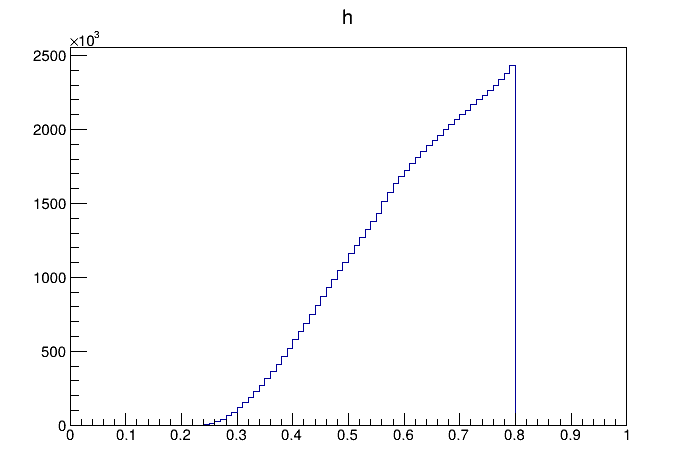

In [6]:
c = ROOT.TCanvas()
h = ROOT.TH1F("h","h",100,0,1)
h.SetStats(0)

chain.Draw("y>>h")
c.Draw()

## Calculating Asymmetries

Note: the inbending and outbending data have a different polarization value...

In [7]:
f = ROOT.TFile("out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root")
f.ls()

TFile**		out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root	
 TFile*		out/pippi0_fall2018_in_pass1/pippi0_fall2018_in_pass1.root	
  KEY: TTree	EventTree;1	EventTree
  KEY: TTree	MLinput;1	Nearest neighbor information
  KEY: TTree	pippi0;1	Tree


In [8]:
t_pippi0 = f.Get("pippi0")
t_EventTree = f.Get("EventTree")
[print(b.GetName()) for b in  t_pippi0.GetListOfBranches()]
#[print(b.GetName()) for b in  t_EventTree.GetListOfBranches()]

t_EventTree.GetEntry(0)
Pb = t_EventTree.Pol
print(Pb)

#print("EventTree: ",t_EventTree.GetEntries())
#print("pippi0: ",t_pippi0.GetEntries())

hel
run
x
eps
gamma
x_true
Q2
Q2_true
z
pT
xF
xF1
xF2
phi
Mx
Mh
z_true
pT_true
xF_true
xF1_true
xF2_true
phi_true
Mx_true
Mh_true
Mdiphoton
Mdiphoton_true
th
th_true
cth
cth_true
0.8592000007629395


### MLM Function

In [ ]:
z = ROOT.RooRealVar("z","z",0,1)
mean = ROOT.RooRealVar("mean","mean",0.95,0,1)
sigma = ROOT.RooRealVar("sigma","sigma",0.26,0.01,1)
amp = ROOT.RooRealVar("amp","amp",500,0,10000000)

#setup the PDF
gauss = ROOT.RooGenericPdf("gauss","gauss",
                          "exp(-(z-mean)^2/(2*sigma^2))",
                          ROOT.RooArgSet(z,sigma,mean))

gext = ROOT.RooAddPdf("gext", "extended gaiss", ROOT.RooArgList(gauss), ROOT.RooArgList(amp))

#setupt the data
data = ROOT.RooDataSet("data", "dataset with z", chain, ROOT.RooArgSet(z))

#perform the fit
fitResult = gext.fitTo(data,ROOT.RooFit.Extended(True),PrintLevel=-1)

mean.Print()
sigma.Print()
amp.Print()

zframe = z.frame(Title="z gaussian fit")
gext.plotOn(zframe)
#data.plotOn(zframe)

c = ROOT.TCanvas()
zframe.Draw()
c.Draw()

In [17]:
#This code block performs a simultaneous fit with two different models to two different data subsets within the same set
#NOTE: Pb is set manually for inbending data


def simFit(t_pos,t_neg,i):
    #----------------------------------------------------------------------
    #create models for positive and negative helicity probability
    #observeable:
    A = ROOT.RooRealVar("A","A",-1,1)
    #postive:
    eps = ROOT.RooRealVar("eps","eps",0.6,0,1)
    phi = ROOT.RooRealVar("phi","phi",0,-3.25,3.25)
    pos_expr = "1+0.8592000007629395*sqrt(2*eps*(1-eps))*A*sin(phi)"
    pos_model = ROOT.RooGenericPdf("PosProbFxn","PositiveHelicityPDF",
                              pos_expr,
                              ROOT.RooArgSet(A,eps,phi))
    
    #negative:
    neg_expr = "1-0.8592000007629395*sqrt(2*eps*(1-eps))*A*sin(phi)"
    neg_model = ROOT.RooGenericPdf("NegProbFxn","PositiveHelicityPDF",
                              neg_expr,
                              ROOT.RooArgSet(A,eps,phi))
    
    
    #----------------------------------------------------------------------
    #prepare data that should be fit to this model
    posData = ROOT.RooDataSet("posData", "pos helicity data", t_pos, ROOT.RooArgSet(eps,phi))
    negData = ROOT.RooDataSet("negData","neg helicity data", t_neg, ROOT.RooArgSet(eps,phi))
    
    #----------------------------------------------------------------------
    #perform the simultaneous fit
    helicity = ROOT.RooCategory("helicity","helicity")
    helicity.defineType("pos")
    helicity.defineType("neg")
    
    combData = ROOT.RooDataSet("combData","combined Data", 
                               ROOT.RooArgSet(eps,phi), 
                               Index = helicity, 
                               Import = {"pos":posData, "neg": negData})
    
    simPdf = ROOT.RooSimultaneous("simPdf", "simultaneous pdf", {"pos": pos_model, "neg": neg_model}, helicity)
    
    fitResult = simPdf.fitTo(combData,
                             PrintLevel=-1, Save=True,Timer=True,Extended=True)
    frame = phi.frame(-3.14, 3.14);
    combData.plotOn(frame, ROOT.RooFit.MarkerSize(0.5), ROOT.RooFit.Name("data"));
    simPdf.plotOn(frame, ROOT.RooFit.LineStyle(ROOT.kDashed), ROOT.RooFit.LineColor(ROOT.kBlack), ROOT.RooFit.Name("MLMFit"));

    c10 = ROOT.TCanvas()
    frame.Draw()
    c10.SaveAs(f"out/test/test{i}.png")
    
    
    return A


In [7]:
#based on the bin edges, find the strings used to make the bin cuts and find the points at which to plot later
zbin_edges = np.linspace(0.5,1,11)#[0.66, 0.74, 0.79, 0.82, 0.85, 0.88, 0.91, 0.93, 0.96, 1]

zbins = []
for edge_idx in range(len(zbin_edges)-1):
    string = "&&z>"+str(zbin_edges[edge_idx])+" && z<"+str(zbin_edges[edge_idx+1])
    zbins.append(string)

zbin_centers = []
for edge_idx in range(len(zbin_edges)-1):
    center = zbin_edges[edge_idx]+(zbin_edges[edge_idx+1]-zbin_edges[edge_idx])/2
    zbin_centers.append(center)

zbin_errs = []
for edge_idx in range(len(zbin_edges)-1):
    err = (zbin_edges[edge_idx+1]-zbin_edges[edge_idx])/2
    zbin_errs.append(err)
print(zbins)

['&&z>0.5 && z<0.55', '&&z>0.55 && z<0.6', '&&z>0.6 && z<0.65', '&&z>0.65 && z<0.7', '&&z>0.7 && z<0.75', '&&z>0.75 && z<0.8', '&&z>0.8 && z<0.8500000000000001', '&&z>0.8500000000000001 && z<0.9', '&&z>0.9 && z<0.95', '&&z>0.95 && z<1.0']


In [18]:
ROOT.gROOT.cd()
A_results = []
bn_idx = 0
for bn in zbins:
    print("---------------------------------------------------------------------------------")
    print("fitting bin: ",bn_idx)
    t_pos = chain.CopyTree("hel==1 && Mdiphoton<0.16 && 0.115<Mdiphoton && 0.85<Mx && Mx < 1.05"+bn)
    t_neg = chain.CopyTree("hel==-1 && Mdiphoton<0.16 && 0.115<Mdiphoton && 0.85<Mx && Mx < 1.05"+bn)
    A_results.append(simFit(t_pos,t_neg,bn))
    bn_idx+=1

---------------------------------------------------------------------------------
fitting bin:  0
---------------------------------------------------------------------------------
fitting bin:  1
---------------------------------------------------------------------------------
fitting bin:  2
---------------------------------------------------------------------------------
fitting bin:  3
---------------------------------------------------------------------------------
fitting bin:  4
---------------------------------------------------------------------------------
fitting bin:  5
---------------------------------------------------------------------------------
fitting bin:  6
---------------------------------------------------------------------------------
fitting bin:  7
---------------------------------------------------------------------------------
fitting bin:  8
---------------------------------------------------------------------------------
fitting bin:  9
[#1] INFO:Fitting --

Info in <TCanvas::Print>: png file out/test/test&&z>0.5 && z<0.55.png has been created
Info in <TCanvas::Print>: png file out/test/test&&z>0.55 && z<0.6.png has been created
Info in <TCanvas::Print>: png file out/test/test&&z>0.6 && z<0.65.png has been created
IOStream.flush timed out
Info in <TCanvas::Print>: png file out/test/test&&z>0.65 && z<0.7.png has been created
Info in <TCanvas::Print>: png file out/test/test&&z>0.7 && z<0.75.png has been created
IOStream.flush timed out
Info in <TCanvas::Print>: png file out/test/test&&z>0.75 && z<0.8.png has been created
IOStream.flush timed out
Info in <TCanvas::Print>: png file out/test/test&&z>0.8 && z<0.8500000000000001.png has been created
Info in <TCanvas::Print>: png file out/test/test&&z>0.8500000000000001 && z<0.9.png has been created
IOStream.flush timed out
Info in <TCanvas::Print>: png file out/test/test&&z>0.9 && z<0.95.png has been created
Info in <TCanvas::Print>: png file out/test/test&&z>0.95 && z<1.0.png has been created


In [ ]:
print(A_results)

In [ ]:
c = ROOT.TCanvas()
c.SetTickx()
c.SetTicky()
c.SetGridx()
c.SetGridy()

A_vals = [entry.getVal() for entry in A_results]
A_errs = [entry.getError() for entry in A_results]

x = np.array(zbin_centers, dtype='float64')
y = np.array(A_vals, dtype='float64')
x_errs = np.array(zbin_errs,dtype='float64')
y_errs = np.array(A_errs,dtype='float64')

print(x_errs)
gr = ROOT.TGraphErrors(len(x),x,y,x_errs,y_errs)

gr.SetMarkerColor(ROOT.kBlack)
gr.SetMarkerStyle(20)
gr.SetTitle("A_{sig+bkg}")
gr.GetXaxis().SetTitle("z")
gr.GetYaxis().SetTitle("F_{LU}^{sin#phi}/F_{UU}")

leg = ROOT.TLegend(0.15,0.15,0.45,0.25) #xmin,ymin,xmax.ymax
leg.AddEntry(gr,"RGA Fall Inbending Data","p") #name of object being referred, "title shown", (fit line or point)
leg.SetBorderSize(0)

gr.Draw("AP")
leg.Draw()
c.Draw()

